### Preamble
- In this notebook, we will train a deep convolutional GP as an autoencoder for MNIST

In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm import tqdm
from typing import Any, List, Callable
from tempfile import TemporaryDirectory
from itertools import chain
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import pdist
from gpflow.config import default_jitter, default_float as floatx
from tensorflow.python import linalg as tfla
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow_probability.python.bijectors import Sigmoid
from tensorflow.python.keras.utils.conv_utils import (conv_output_length,
                                                      deconv_output_length)

from gpflow_sampling import covariances
from gpflow_sampling.models import PathwiseSVGP
from gpflow_sampling.kernels import Conv2d, Conv2dTranspose
from gpflow_sampling.inducing_variables import InducingImages

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
plt.rc('figure', dpi=256)
plt.rc('font', family='serif', size=12)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'''
       \usepackage{amsmath,amsfonts}
       \renewcommand{\v}[1]{\boldsymbol{#1}}''')

In [3]:
SEED = 2
FLOATX = 'float32'

np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.backend.set_floatx(FLOATX)
gpflow.config.set_default_float(FLOATX)
gpflow.config.set_default_jitter(1e-4 if (FLOATX == 'float32') else 1e-6)

### Prepare dataset

In [4]:
def load_dataset(name: str,
                 batch_size: int, 
                 num_repetitions: int = 1, 
                 global_scale=1.0, 
                 pad: int = 0):
    (train_split, test_split), info = tfds.load(name=name, 
                                                split=['train', 'test'],
                                                shuffle_files=True,
                                                as_supervised=True,
                                                with_info=True)

    count = 0
    for (x, _) in train_split.batch(1024).take(-1):
        x = global_scale * tf.cast(x, floatx())
        size = tf.cast(tf.reduce_prod(x.shape[:-1]), floatx())
        count += size
        if count == size: # channel-wise mean and variance
            mc = tf.reduce_mean(x, axis=[0, 1, 2])  # [C]
            vc = tf.reduce_sum(tf.square(x - mc), axis=[0, 1, 2])
        else:
            res = x - mc
            mc += tf.reduce_sum(res, axis=[0, 1, 2])/count
            vc += tf.reduce_sum(res * (x - mc), axis=[0, 1, 2])
    
    vc /= (count - 1)
    sc = tf.sqrt(vc) + np.finfo(floatx()).eps  # channel-wise standard deviation
    inv_sc = tf.math.reciprocal(sc)

    def preprocess(image, label, loc=mc, inv_scale=inv_sc):
        x = global_scale * tf.cast(image, floatx())
        return tf.pad(inv_scale * (x - loc), [[pad, pad], [pad, pad], [0, 0]])

    train_gen = train_split.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                           .cache()\
                           .shuffle(info.splits['train'].num_examples)\
                           .batch(batch_size)\
                           .repeat(num_repetitions)\
                           .prefetch(tf.data.experimental.AUTOTUNE)

    test_gen = test_split.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .cache()\
                         .batch(batch_size)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
    
    return (train_gen, test_gen), info

In [5]:
(train_gen, test_gen), info = load_dataset(name='mnist', batch_size=128)

### Model abstractions

In [6]:
class IdentityMeanConv2d(gpflow.mean_functions.MeanFunction):
    def __init__(self,
                 filter_shape: List,
                 channels_in: int,
                 channels_out: int,
                 channel_proj: tf.Tensor = None,
                 strides: tuple = (1, 1),
                 padding: str = "VALID"):

        if channel_proj is None:
            if channels_in == channels_out:
                channel_proj = tf.eye(channels_in, dtype=floatx())
            else:
                random_proj = tf.random.normal([channels_out, channels_in], dtype=floatx())
                channel_proj = tf.linalg.l2_normalize(random_proj, axis=-1)

        if not isinstance(channel_proj, gpflow.Parameter):
            channel_proj = gpflow.Parameter(channel_proj)

        self.strides = strides
        self.padding = padding
        self.channels_in = channels_in
        self.channels_out = channels_out
        self.channel_proj = channel_proj
        self.filter_shape = filter_shape
    
    def __call__(self, x):
        spatial_out = self.get_spatial_out(x.shape[1:3])
        return tf.matmul(tf.image.resize(x, spatial_out), 
                         self.channel_proj,
                         transpose_b=True)

    def get_spatial_out(self, spatial_in):
        return [conv_output_length(input_length=xlen,
                                   filter_size=fsize,
                                   stride=stride,
                                   padding=self.padding.lower())
                for xlen, fsize, stride in zip(spatial_in, self.filter_shape, self.strides)]
        
    
class IdentityMeanConv2dTranspose(IdentityMeanConv2d):
    def get_spatial_out(self, spatial_in):
        return [deconv_output_length(input_length=xlen,
                                   filter_size=fsize,
                                   stride=stride,
                                   padding=self.padding.lower())
                for xlen, fsize, stride in zip(spatial_in, self.filter_shape, self.strides)]

In [7]:
class ConvLayer(PathwiseSVGP):
    def __call__(self, 
                 X: tf.Tensor,
                 num_bases: int = 256,
                 num_samples: int = None,
                 sample_axis: int = "default",
                 **kwargs):
        """
        Evaluate conditioned paths. By default, we evaluate a
        different sample path for each image in X.
        """
        if sample_axis == "default":  
            sample_axis = 0 if (num_samples is None) else None
        
        if num_samples is None:
            num_samples = X.shape[0]
        
        with self.temporary_paths(num_bases=num_bases,
                                  num_samples=num_samples, 
                                  sample_axis=sample_axis,
                                  **kwargs):

            return self.predict_f_samples(X)

    @classmethod
    def build(cls,
              images: tf.Tensor,
              num_inducing: int,
              patch_shape: List,
              strides: List = None,
              padding: str = "VALID",
              dilations: List = None,
              channels_out: int = 1,
              likelihood: object = None,
              mean_function: object = None,
              kernel_cls: Callable = Conv2d,
              mean_function_cls: Callable = IdentityMeanConv2d,
              **kwargs):
        
        # Collect some shape info
        image_shape = list(images.shape[1:3])
        channels_in = images.shape[-1]
        patch_len = channels_in * np.prod(patch_shape)
        if strides is None:
            strides = [1, 1]
        
        if dilations is None: 
            dilations = [1, 1]
        
        if mean_function is None:
            mean_function = mean_function_cls(strides=strides,
                                              padding=padding,
                                              channels_in=channels_in,
                                              channels_out=channels_out,
                                              filter_shape=patch_shape)

        # Initialize a kernel
        ls = np.full([patch_len], 1.0)
        base = gpflow.kernels.SquaredExponential(lengthscales=ls) 
        kern = kernel_cls(kernel=base,
                          weights=None,  # we do not reduce over spatial features
                          strides=strides,
                          padding=padding,
                          patch_shape=patch_shape,
                          image_shape=image_shape,
                          channels_in=channels_in,
                          channels_out=channels_out,
                          dilations=dilations)

        # Initialize kernel/variational parameters
        with tf.device('cpu'):
            patches = kern.get_patches(images, full_spatial=False)
            patches = tf.reshape(patches, [-1, patches.shape[-1]]).numpy()

        Z = cls._patch_initializer(num_inducing, patches, patch_shape)
        kern.kernel.lengthscales = cls._lengthscales_initializer(patches)
        return cls(kernel=kern,
                   likelihood=likelihood,
                   mean_function=mean_function,
                   inducing_variable=Z,
                   num_latent_gps=channels_out,
                   **kwargs)
    
    @classmethod
    def _patch_initializer(cls, m, x: np.ndarray, patch_shape: List):
        """
        Initialize inducing image patches using k-means.
        """
        assert len(patch_shape) == 2 and patch_shape[0] == patch_shape[1]
        kmeans = MiniBatchKMeans(n_clusters=m, init='k-means++', batch_size=1024)
        kmeans.fit(x)
        
        vecs = kmeans.cluster_centers_
        init = tf.nn.depth_to_space(vecs[:, None, None, :], patch_shape[0])
        return InducingImages(init)
    
    @classmethod
    def _lengthscales_initializer(cls,
                                  x: np.ndarray,
                                  minval: float = 1e-2,
                                  maxval: float = 1e4):
        """
        Initialize kernel lengthscales using the median heuristic.
        """
        if len(x) > 10000:
            choices = np.random.choice(len(x), size=10000, replace=False)
            x = np.take(x, choices, axis=0)

        _min = None if (minval is None) else 3/2 * minval
        _max = None if (maxval is None) else 2/3 * maxval
        dist = pdist(x, metric='euclidean')
        init = np.full(x.shape[-1],
                       np.clip(np.sqrt(0.5) * np.median(dist), _min, _max))

        if maxval is None:
            transform = gpflow.utilities.positive(lower=minval)
        else:
            transform = Sigmoid(low=tf.cast(minval, floatx()),
                                high=tf.cast(maxval, floatx()))

        return gpflow.Parameter(init, transform=transform)


class TransposeConvLayer(ConvLayer):
    @classmethod
    def build(cls,
              *args, 
              kernel_cls: Callable = Conv2dTranspose,
              mean_function_cls: Callable = IdentityMeanConv2dTranspose,
              **kwargs):
        return super(TransposeConvLayer, cls).build(*args,
                                                     kernel_cls=kernel_cls,
                                                     mean_function_cls=mean_function_cls,
                                                     **kwargs)

In [8]:
class Sequential(tf.Module):
    def __init__(self, layers: List = None, **kwargs):
        if layers is None:
            layers = list()

        super().__init__(**kwargs)
        self.layers = layers
    
    def __call__(self, x, **kwargs):
        x = tf.convert_to_tensor(x, dtype=floatx())
        for layer in self.layers:
            x = layer(x, **kwargs)
        return x

### Construct autoencoder model

In [9]:
# Fetch some initial input features
with tf.device('cpu'):
    feat = train_gen.unbatch()\
                    .shuffle(info.splits['train'].num_examples)\
                    .take(10000)
    feat = tf.stack(tuple(feat))  # [10000, 28, 28, 1]

In [10]:
depth = 3
patch_shape = [3, 3]
num_inducing = 384
channels_out = 32

In [11]:
# Construct encoder model
encoder = Sequential()
for t in range(depth):
    top = t == depth - 1
    layer = ConvLayer.build(images=feat,
                            patch_shape=patch_shape,
                            num_inducing=num_inducing,
                            strides=[1, 1] if top else [2, 2],
                            padding="VALID" if top else "SAME",
                            channels_out=1 if top else channels_out)

    layer.q_sqrt.assign(1e-5 * layer.q_sqrt)
    encoder.layers.append(layer)
        
    # Prepare features for next layer
    with tf.device('cpu'):  
        next_feat = layer.mean_function(feat) 
    print(f"{tuple(feat.shape[1:])} ==> {tuple(next_feat.shape[1:])}")
    feat = next_feat

(28, 28, 1) ==> (14, 14, 32)
(14, 14, 32) ==> (7, 7, 32)
(7, 7, 32) ==> (5, 5, 1)


In [12]:
# Construct decoder model
decoder = Sequential()
for t in range(depth + 1):
    bot = t == 0
    top = t == depth

    cls = ConvLayer if top else TransposeConvLayer
    layer = cls.build(images=feat,
                      patch_shape=patch_shape,
                      num_inducing=num_inducing,
                      strides=[1, 1] if (top or bot) else [2, 2],
                      padding="VALID" if bot else "SAME",
                      channels_out=1 if top else channels_out)

    layer.q_sqrt.assign(1e-5 * layer.q_sqrt)
    decoder.layers.append(layer)

    # Prepare features for next layer
    with tf.device('cpu'):
        next_feat = layer.mean_function(feat[:1] if top else feat)
    print(f"{tuple(feat.shape[1:])} ==> {tuple(next_feat.shape[1:])}")
    feat = next_feat

(5, 5, 1) ==> (7, 7, 32)
(7, 7, 32) ==> (14, 14, 32)
(14, 14, 32) ==> (28, 28, 32)
(28, 28, 32) ==> (28, 28, 1)


### Sample-based training

In [13]:
@tf.function
def eval_metrics(images, num_data=info.splits['train'].num_examples):  
    encodings = encoder(images)
    decodings = decoder(encodings)
    
    # Compute mean square error averaged over the given batch of examples
    err = tf.square(images - decodings)
    mse = tf.reduce_sum(tf.reduce_mean(err, axis=0))
    loss = num_data * mse
    for svgp in chain(encoder.layers, decoder.layers):
        loss += svgp.prior_kl()
    return loss, mse

In [14]:
num_steps = 10000
step_sizes = 1e-2, 1e-3, 1e-4, 1e-5
boundaries = [k * num_steps//len(step_sizes) for k in range(1, len(step_sizes))]
schedule = PiecewiseConstantDecay(boundaries, step_sizes)

optimizer = tf.optimizers.Adam(schedule)
variables = list(encoder.trainable_variables) + list(decoder.trainable_variables)

with TemporaryDirectory() as logdir:
    try:
        writer = tf.summary.create_file_writer(logdir)
        with writer.as_default():
            step_iterator = tqdm(range(num_steps))
            for step in step_iterator:
                with tf.GradientTape(watch_accessed_variables=False) as tape:
                    tape.watch(variables)
                    images = next(iter(train_gen.take(1)))
                    loss, mse = eval_metrics(images)

                grads = tape.gradient(loss, variables)
                grads_and_vars = tuple(zip(grads, variables))
                optimizer.apply_gradients(grads_and_vars)

                mse_ema = mse if (step == 0) else mse_ema + 0.25 * (mse - mse_ema)
                loss_ema = loss if (step == 0) else loss_ema + 0.25 * (loss - loss_ema)
                step_iterator.set_postfix_str(f'EMA(loss): {loss_ema:.3e}, EMA(mse): {mse_ema:.3e}')
                tf.summary.scalar('mse', mse, step=step)
                tf.summary.scalar('loss', loss, step=step)
    finally:
        writer.close()

100%|██████████| 10000/10000 [40:37<00:00,  4.10it/s, EMA(loss): 6.058e+06, EMA(mse): 9.755e+01]


### Visualize

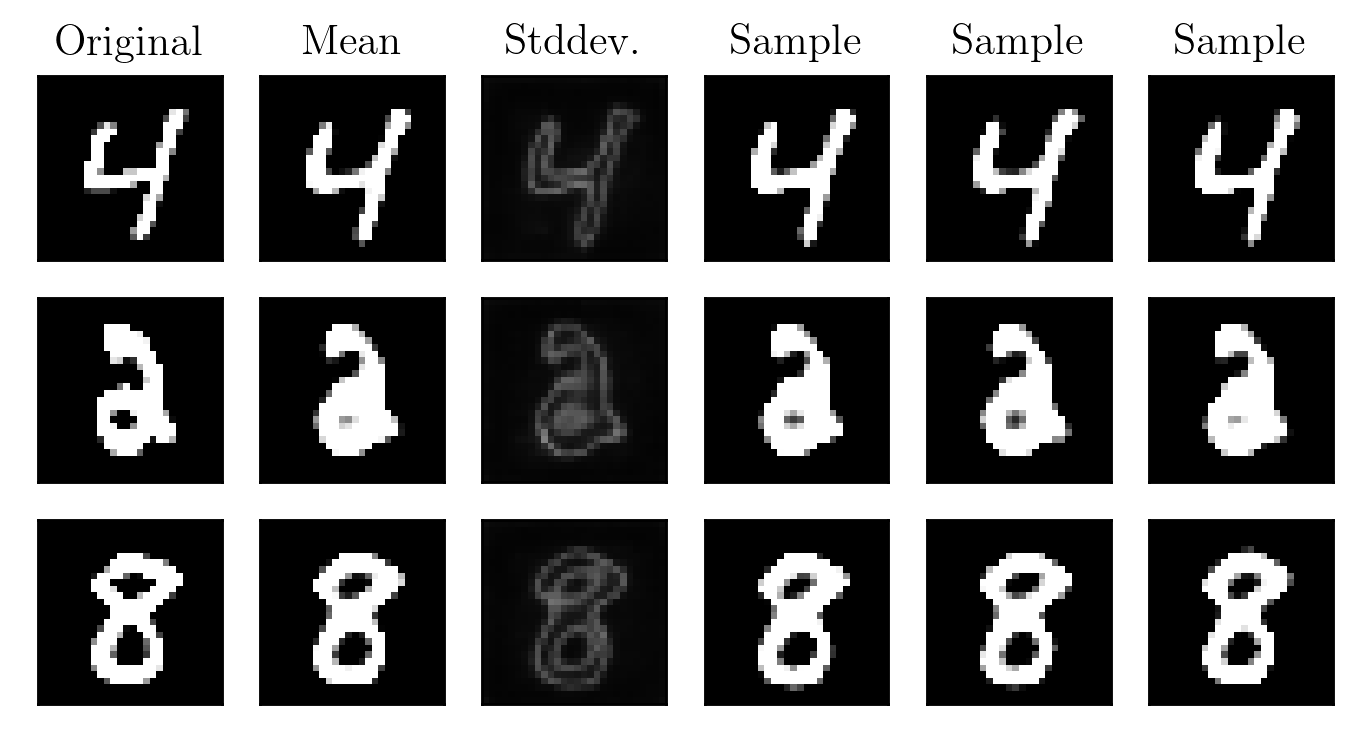

In [15]:
plt.rc('figure', dpi=256)

N = 3
S = 1000
X = tf.stack(tuple(test_gen.unbatch().shuffle(10000).take(N)))
with tf.device('cpu'):
    X_tiled = tf.tile(X, [S, 1, 1, 1])
    Xhat = tf.reshape(decoder(encoder(X_tiled)), [S, N] + list(X.shape[1:]))

loc = tf.reduce_mean(Xhat, axis=0)
scale = tf.sqrt(tf.reduce_mean(tf.square(Xhat - loc), axis=0))

fig = plt.figure(111, figsize=(7, 3.25))
axes = np.asarray(ImageGrid(fig,
                            111,
                            nrows_ncols=(N, 6),
                            axes_pad=0.15,
                            share_all=True,
                            cbar_mode="None",
                            cbar_location="right",
                            cbar_size="10%",
                            cbar_pad=0.15)).reshape(N, 6)

for ax in np.ravel(axes):
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect(aspect='equal')

axes[0, 0].set_title("Original")
axes[0, 1].set_title("Mean")
axes[0, 2].set_title("Stddev.")
for ax in axes[0, 3:]:
    ax.set_title('Sample')

for i, x in enumerate(X):
    axes[i, 0].imshow(tf.squeeze(x), cmap='gist_gray', vmin=0, vmax=1)
    axes[i, 1].imshow(tf.squeeze(loc[i]), cmap='gist_gray', vmin=0, vmax=1)
    axes[i, 2].imshow(tf.squeeze(scale[i]), cmap='gist_gray', vmin=0, vmax=1)
    for j in range(3):
        _ = axes[i, 3 + j].imshow(tf.squeeze(Xhat[j, i]), cmap='gist_gray', vmin=0, vmax=1)